In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

matplotlib.style.use('ggplot')

C:\Users\Achu\miniconda3\envs\Projekt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
PATH = "D:/Achintya/Projects/GAN/outputs_mnist/"

In [4]:
# learning parameters

batch_size = 512
epochs = 500
sample_size = 64 
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

In [6]:
train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [7]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
        
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [9]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

print('##### GENERATOR #####')
print(generator)

print('######################')

print('\n##### DISCRIMINATOR #####')
print(discriminator)

print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

In [10]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [11]:
# loss function
criterion = nn.BCELoss()

In [12]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [13]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)

# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [14]:
# function to create the noise 
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [15]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [16]:
# train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    
    optimizer.zero_grad()
    
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    
    loss_real.backward()
    loss_fake.backward()
    
    optimizer.step()
    
    return loss_real + loss_fake

In [17]:
# train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    
    real_label = label_real(b_size)
    
    optimizer.zero_grad()
    
    output = discriminator(data_fake)
    
    loss = criterion(output, real_label)
    
    loss.backward()
    
    optimizer.step()
    
    return loss

In [18]:
# create the noise 
noise = create_noise(sample_size, nz)

In [19]:
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [19]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
            
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
        
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, PATH+f"gen_img{epoch}.png")
    images.append(generated_img)
    
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch 
    
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")
    
    if epoch % 10 == 0:
        checkpoint_generator = {
            "epoch": epoch,
            "model_state": generator.state_dict(),
            "optim_state": optim_g.state_dict()
        }
        
        checkpoint_discriminator = {
            "epoch": epoch,
            "model_state": discriminator.state_dict(),
            "optim_state": optim_d.state_dict()
        }
        
        torch.save(checkpoint_generator, PATH+"checkpoint_gen.pth")
        torch.save(checkpoint_discriminator, PATH+"checkpoint_disc.pth")

118it [00:20,  5.81it/s]                                                                                               


Epoch 0 of 500
Generator loss: 1.52409136, Discriminator loss: 0.84162903


118it [00:16,  7.14it/s]                                                                                               


Epoch 1 of 500
Generator loss: 2.97365451, Discriminator loss: 1.23079586


118it [00:17,  6.92it/s]                                                                                               


Epoch 2 of 500
Generator loss: 4.02273941, Discriminator loss: 0.79638839


118it [00:17,  6.75it/s]                                                                                               


Epoch 3 of 500
Generator loss: 3.12176180, Discriminator loss: 1.08044636


118it [00:17,  6.75it/s]                                                                                               


Epoch 4 of 500
Generator loss: 1.92643034, Discriminator loss: 0.95907807


118it [00:17,  6.88it/s]                                                                                               


Epoch 5 of 500
Generator loss: 1.68367100, Discriminator loss: 1.08562088


118it [00:16,  6.96it/s]                                                                                               


Epoch 6 of 500
Generator loss: 1.45723295, Discriminator loss: 1.31562960


118it [00:18,  6.51it/s]                                                                                               


Epoch 7 of 500
Generator loss: 1.36903274, Discriminator loss: 1.06684601


118it [00:16,  7.01it/s]                                                                                               


Epoch 8 of 500
Generator loss: 1.59761906, Discriminator loss: 1.08971107


118it [00:17,  6.90it/s]                                                                                               


Epoch 9 of 500
Generator loss: 1.36428738, Discriminator loss: 0.99308681


118it [00:17,  6.93it/s]                                                                                               


Epoch 10 of 500
Generator loss: 1.52866960, Discriminator loss: 0.97448111


118it [00:18,  6.54it/s]                                                                                               


Epoch 11 of 500
Generator loss: 2.07637405, Discriminator loss: 0.77105165


118it [00:17,  6.89it/s]                                                                                               


Epoch 12 of 500
Generator loss: 2.92928624, Discriminator loss: 0.97116023


118it [00:17,  6.70it/s]                                                                                               


Epoch 13 of 500
Generator loss: 2.02591920, Discriminator loss: 1.01317048


118it [00:19,  6.11it/s]                                                                                               


Epoch 14 of 500
Generator loss: 2.28194308, Discriminator loss: 0.81026042


118it [00:20,  5.77it/s]                                                                                               


Epoch 15 of 500
Generator loss: 1.96675932, Discriminator loss: 0.63432437


118it [00:18,  6.42it/s]                                                                                               


Epoch 16 of 500
Generator loss: 2.06989336, Discriminator loss: 0.89563334


118it [00:20,  5.90it/s]                                                                                               


Epoch 17 of 500
Generator loss: 1.94606376, Discriminator loss: 0.89026999


118it [00:18,  6.45it/s]                                                                                               


Epoch 18 of 500
Generator loss: 2.29332447, Discriminator loss: 0.77522510


118it [00:16,  6.94it/s]                                                                                               


Epoch 19 of 500
Generator loss: 2.22924900, Discriminator loss: 0.67434430


118it [00:18,  6.23it/s]                                                                                               


Epoch 20 of 500
Generator loss: 2.59775162, Discriminator loss: 0.42026761


118it [00:18,  6.48it/s]                                                                                               


Epoch 21 of 500
Generator loss: 3.25457215, Discriminator loss: 0.38257122


118it [00:19,  6.15it/s]                                                                                               


Epoch 22 of 500
Generator loss: 2.71488214, Discriminator loss: 0.66097462


118it [00:18,  6.53it/s]                                                                                               


Epoch 23 of 500
Generator loss: 2.64340615, Discriminator loss: 0.66149163


118it [00:17,  6.65it/s]                                                                                               


Epoch 24 of 500
Generator loss: 2.82707143, Discriminator loss: 0.47399035


118it [00:19,  5.96it/s]                                                                                               


Epoch 25 of 500
Generator loss: 2.54899955, Discriminator loss: 0.66792315


118it [00:18,  6.44it/s]                                                                                               


Epoch 26 of 500
Generator loss: 3.02697706, Discriminator loss: 0.43959406


118it [00:17,  6.57it/s]                                                                                               


Epoch 27 of 500
Generator loss: 3.50024629, Discriminator loss: 0.55627787


118it [00:19,  6.01it/s]                                                                                               


Epoch 28 of 500
Generator loss: 2.40699720, Discriminator loss: 0.68594658


118it [00:18,  6.43it/s]                                                                                               


Epoch 29 of 500
Generator loss: 3.00561333, Discriminator loss: 0.44778439


118it [00:17,  6.85it/s]                                                                                               


Epoch 30 of 500
Generator loss: 3.22230387, Discriminator loss: 0.49439561


118it [00:16,  6.96it/s]                                                                                               


Epoch 31 of 500
Generator loss: 2.99159670, Discriminator loss: 0.57889378


118it [00:18,  6.53it/s]                                                                                               


Epoch 32 of 500
Generator loss: 2.93855882, Discriminator loss: 0.49994913


118it [00:17,  6.59it/s]                                                                                               


Epoch 33 of 500
Generator loss: 2.92079639, Discriminator loss: 0.56235546


118it [00:17,  6.94it/s]                                                                                               


Epoch 34 of 500
Generator loss: 2.57626033, Discriminator loss: 0.63020289


118it [00:17,  6.64it/s]                                                                                               


Epoch 35 of 500
Generator loss: 2.78233671, Discriminator loss: 0.48767915


118it [00:17,  6.69it/s]                                                                                               


Epoch 36 of 500
Generator loss: 2.81134963, Discriminator loss: 0.50258887


118it [00:17,  6.77it/s]                                                                                               


Epoch 37 of 500
Generator loss: 2.85795569, Discriminator loss: 0.44692069


118it [00:16,  6.95it/s]                                                                                               


Epoch 38 of 500
Generator loss: 3.03093171, Discriminator loss: 0.53812075


118it [00:17,  6.85it/s]                                                                                               


Epoch 39 of 500
Generator loss: 2.78494072, Discriminator loss: 0.54579663


118it [00:18,  6.43it/s]                                                                                               


Epoch 40 of 500
Generator loss: 3.10426903, Discriminator loss: 0.48012939


118it [00:17,  6.82it/s]                                                                                               


Epoch 41 of 500
Generator loss: 3.23703647, Discriminator loss: 0.50106233


118it [00:17,  6.85it/s]                                                                                               


Epoch 42 of 500
Generator loss: 2.95796442, Discriminator loss: 0.50275648


118it [00:18,  6.49it/s]                                                                                               


Epoch 43 of 500
Generator loss: 2.80053043, Discriminator loss: 0.52585959


118it [00:17,  6.68it/s]                                                                                               


Epoch 44 of 500
Generator loss: 2.93807507, Discriminator loss: 0.47489381


118it [00:17,  6.76it/s]                                                                                               


Epoch 45 of 500
Generator loss: 3.08325076, Discriminator loss: 0.52243406


118it [00:19,  5.96it/s]                                                                                               


Epoch 46 of 500
Generator loss: 2.63282275, Discriminator loss: 0.53401142


118it [00:18,  6.34it/s]                                                                                               


Epoch 47 of 500
Generator loss: 2.74024844, Discriminator loss: 0.55204326


118it [00:17,  6.66it/s]                                                                                               


Epoch 48 of 500
Generator loss: 2.58184791, Discriminator loss: 0.58814031


118it [00:17,  6.85it/s]                                                                                               


Epoch 49 of 500
Generator loss: 2.73154759, Discriminator loss: 0.55031645


118it [00:17,  6.84it/s]                                                                                               


Epoch 50 of 500
Generator loss: 2.86497736, Discriminator loss: 0.51223516


118it [00:18,  6.40it/s]                                                                                               


Epoch 51 of 500
Generator loss: 2.74223447, Discriminator loss: 0.54079831


118it [00:17,  6.79it/s]                                                                                               


Epoch 52 of 500
Generator loss: 2.60746455, Discriminator loss: 0.58451056


118it [00:17,  6.78it/s]                                                                                               


Epoch 53 of 500
Generator loss: 2.44683433, Discriminator loss: 0.62317365


118it [00:18,  6.43it/s]                                                                                               


Epoch 54 of 500
Generator loss: 2.64792323, Discriminator loss: 0.56408525


118it [00:18,  6.48it/s]                                                                                               


Epoch 55 of 500
Generator loss: 2.63967943, Discriminator loss: 0.52490687


118it [00:17,  6.94it/s]                                                                                               


Epoch 56 of 500
Generator loss: 2.74049187, Discriminator loss: 0.52020282


118it [00:17,  6.64it/s]                                                                                               


Epoch 57 of 500
Generator loss: 2.73094559, Discriminator loss: 0.58261299


118it [00:17,  6.60it/s]                                                                                               


Epoch 58 of 500
Generator loss: 2.50815320, Discriminator loss: 0.64480007


118it [00:17,  6.65it/s]                                                                                               


Epoch 59 of 500
Generator loss: 2.40373874, Discriminator loss: 0.68178779


118it [00:17,  6.72it/s]                                                                                               


Epoch 60 of 500
Generator loss: 2.44421482, Discriminator loss: 0.58892447


118it [00:17,  6.62it/s]                                                                                               


Epoch 61 of 500
Generator loss: 2.61737108, Discriminator loss: 0.57134861


118it [00:18,  6.22it/s]                                                                                               


Epoch 62 of 500
Generator loss: 2.41270566, Discriminator loss: 0.61011422


118it [00:17,  6.85it/s]                                                                                               


Epoch 63 of 500
Generator loss: 2.50818801, Discriminator loss: 0.61311018


118it [00:17,  6.58it/s]                                                                                               


Epoch 64 of 500
Generator loss: 2.35072803, Discriminator loss: 0.67092121


118it [00:19,  6.19it/s]                                                                                               


Epoch 65 of 500
Generator loss: 2.45319319, Discriminator loss: 0.62334716


118it [00:17,  6.69it/s]                                                                                               


Epoch 66 of 500
Generator loss: 2.47477794, Discriminator loss: 0.61574745


118it [00:18,  6.47it/s]                                                                                               


Epoch 67 of 500
Generator loss: 2.57065678, Discriminator loss: 0.63223159


118it [00:17,  6.61it/s]                                                                                               


Epoch 68 of 500
Generator loss: 2.48826003, Discriminator loss: 0.65074104


118it [00:18,  6.45it/s]                                                                                               


Epoch 69 of 500
Generator loss: 2.31704783, Discriminator loss: 0.68936229


118it [00:18,  6.46it/s]                                                                                               


Epoch 70 of 500
Generator loss: 2.27851653, Discriminator loss: 0.69146264


118it [00:17,  6.79it/s]                                                                                               


Epoch 71 of 500
Generator loss: 2.34800839, Discriminator loss: 0.68996412


118it [00:17,  6.66it/s]                                                                                               


Epoch 72 of 500
Generator loss: 2.23434019, Discriminator loss: 0.70026559


118it [00:18,  6.39it/s]                                                                                               


Epoch 73 of 500
Generator loss: 2.40895081, Discriminator loss: 0.62858665


118it [00:17,  6.79it/s]                                                                                               


Epoch 74 of 500
Generator loss: 2.23589873, Discriminator loss: 0.69467312


118it [00:17,  6.64it/s]                                                                                               


Epoch 75 of 500
Generator loss: 2.23033929, Discriminator loss: 0.72911423


118it [00:17,  6.64it/s]                                                                                               


Epoch 76 of 500
Generator loss: 2.13011599, Discriminator loss: 0.70539790


118it [00:19,  6.21it/s]                                                                                               


Epoch 77 of 500
Generator loss: 2.34269691, Discriminator loss: 0.64667225


118it [00:18,  6.53it/s]                                                                                               


Epoch 78 of 500
Generator loss: 2.30678344, Discriminator loss: 0.67660266


118it [00:17,  6.63it/s]                                                                                               


Epoch 79 of 500
Generator loss: 2.23707867, Discriminator loss: 0.69126099


118it [00:18,  6.24it/s]                                                                                               


Epoch 80 of 500
Generator loss: 2.23915863, Discriminator loss: 0.67123282


118it [00:17,  6.58it/s]                                                                                               


Epoch 81 of 500
Generator loss: 2.26228523, Discriminator loss: 0.70465750


118it [00:17,  6.63it/s]                                                                                               


Epoch 82 of 500
Generator loss: 2.34229279, Discriminator loss: 0.68883729


118it [00:18,  6.44it/s]                                                                                               


Epoch 83 of 500
Generator loss: 2.38445640, Discriminator loss: 0.70289797


118it [00:18,  6.37it/s]                                                                                               


Epoch 84 of 500
Generator loss: 2.22065020, Discriminator loss: 0.71089900


118it [00:18,  6.54it/s]                                                                                               


Epoch 85 of 500
Generator loss: 2.09217954, Discriminator loss: 0.72243750


118it [00:17,  6.60it/s]                                                                                               


Epoch 86 of 500
Generator loss: 2.09125948, Discriminator loss: 0.71318805


118it [00:19,  6.09it/s]                                                                                               


Epoch 87 of 500
Generator loss: 2.09351230, Discriminator loss: 0.75940329


118it [00:17,  6.63it/s]                                                                                               


Epoch 88 of 500
Generator loss: 1.97476983, Discriminator loss: 0.79577994


118it [00:17,  6.59it/s]                                                                                               


Epoch 89 of 500
Generator loss: 2.00494099, Discriminator loss: 0.78573632


118it [00:17,  6.56it/s]                                                                                               


Epoch 90 of 500
Generator loss: 2.08082795, Discriminator loss: 0.75578749


118it [00:18,  6.31it/s]                                                                                               


Epoch 91 of 500
Generator loss: 2.08102059, Discriminator loss: 0.75079167


118it [00:18,  6.54it/s]                                                                                               


Epoch 92 of 500
Generator loss: 2.00008845, Discriminator loss: 0.77469748


118it [00:17,  6.69it/s]                                                                                               


Epoch 93 of 500
Generator loss: 1.96485722, Discriminator loss: 0.78552955


118it [00:18,  6.45it/s]                                                                                               


Epoch 94 of 500
Generator loss: 1.99252248, Discriminator loss: 0.76979518


118it [00:20,  5.70it/s]                                                                                               


Epoch 95 of 500
Generator loss: 2.08443236, Discriminator loss: 0.78231496


118it [00:18,  6.34it/s]                                                                                               


Epoch 96 of 500
Generator loss: 1.99503958, Discriminator loss: 0.79010367


118it [00:18,  6.49it/s]                                                                                               


Epoch 97 of 500
Generator loss: 1.90503752, Discriminator loss: 0.80966276


118it [00:19,  6.16it/s]                                                                                               


Epoch 98 of 500
Generator loss: 1.85051262, Discriminator loss: 0.83193457


118it [00:18,  6.49it/s]                                                                                               


Epoch 99 of 500
Generator loss: 1.93008196, Discriminator loss: 0.81012475


118it [00:19,  6.04it/s]                                                                                               


Epoch 100 of 500
Generator loss: 1.86310232, Discriminator loss: 0.82529914


118it [00:19,  6.11it/s]                                                                                               


Epoch 101 of 500
Generator loss: 1.83832479, Discriminator loss: 0.84082210


118it [00:18,  6.23it/s]                                                                                               


Epoch 102 of 500
Generator loss: 1.73873544, Discriminator loss: 0.90405118


118it [00:18,  6.33it/s]                                                                                               


Epoch 103 of 500
Generator loss: 1.80026412, Discriminator loss: 0.83179092


118it [00:18,  6.22it/s]                                                                                               


Epoch 104 of 500
Generator loss: 1.79744327, Discriminator loss: 0.85217816


118it [00:19,  6.14it/s]                                                                                               


Epoch 105 of 500
Generator loss: 1.70695293, Discriminator loss: 0.88046753


118it [00:18,  6.43it/s]                                                                                               


Epoch 106 of 500
Generator loss: 1.78913534, Discriminator loss: 0.85360080


118it [00:17,  6.57it/s]                                                                                               


Epoch 107 of 500
Generator loss: 1.82177413, Discriminator loss: 0.84923732


118it [00:18,  6.25it/s]                                                                                               


Epoch 108 of 500
Generator loss: 1.76357269, Discriminator loss: 0.83775437


118it [00:19,  6.17it/s]                                                                                               


Epoch 109 of 500
Generator loss: 1.77924585, Discriminator loss: 0.86326027


118it [00:19,  6.11it/s]                                                                                               


Epoch 110 of 500
Generator loss: 1.80822003, Discriminator loss: 0.86126196


118it [00:18,  6.46it/s]                                                                                               


Epoch 111 of 500
Generator loss: 1.67168987, Discriminator loss: 0.93209207


118it [00:19,  6.08it/s]                                                                                               


Epoch 112 of 500
Generator loss: 1.63796306, Discriminator loss: 0.91423613


118it [00:18,  6.42it/s]                                                                                               


Epoch 113 of 500
Generator loss: 1.64927864, Discriminator loss: 0.89701176


118it [00:19,  6.18it/s]                                                                                               


Epoch 114 of 500
Generator loss: 1.64807057, Discriminator loss: 0.91236848


118it [00:20,  5.81it/s]                                                                                               


Epoch 115 of 500
Generator loss: 1.64106536, Discriminator loss: 0.91717750


118it [00:18,  6.55it/s]                                                                                               


Epoch 116 of 500
Generator loss: 1.65358245, Discriminator loss: 0.90858531


118it [00:17,  6.73it/s]                                                                                               


Epoch 117 of 500
Generator loss: 1.70436931, Discriminator loss: 0.91057354


118it [00:17,  6.70it/s]                                                                                               


Epoch 118 of 500
Generator loss: 1.62389600, Discriminator loss: 0.93928319


118it [00:18,  6.48it/s]                                                                                               


Epoch 119 of 500
Generator loss: 1.72362053, Discriminator loss: 0.88481456


118it [00:18,  6.51it/s]                                                                                               


Epoch 120 of 500
Generator loss: 1.71828628, Discriminator loss: 0.89976394


118it [00:17,  6.91it/s]                                                                                               


Epoch 121 of 500
Generator loss: 1.69047892, Discriminator loss: 0.88037938


118it [00:18,  6.52it/s]                                                                                               


Epoch 122 of 500
Generator loss: 1.70443177, Discriminator loss: 0.87328207


118it [00:19,  6.10it/s]                                                                                               


Epoch 123 of 500
Generator loss: 1.78550649, Discriminator loss: 0.87090009


118it [00:17,  6.79it/s]                                                                                               


Epoch 124 of 500
Generator loss: 1.68779492, Discriminator loss: 0.89432710


118it [00:21,  5.56it/s]                                                                                               


Epoch 125 of 500
Generator loss: 1.66645014, Discriminator loss: 0.90652847


118it [00:20,  5.75it/s]                                                                                               


Epoch 126 of 500
Generator loss: 1.71375525, Discriminator loss: 0.87167907


118it [00:19,  6.08it/s]                                                                                               


Epoch 127 of 500
Generator loss: 1.64835453, Discriminator loss: 0.90363079


118it [00:18,  6.42it/s]                                                                                               


Epoch 128 of 500
Generator loss: 1.60721564, Discriminator loss: 0.91698050


118it [00:21,  5.48it/s]                                                                                               


Epoch 129 of 500
Generator loss: 1.59181416, Discriminator loss: 0.93319541


118it [00:20,  5.63it/s]                                                                                               


Epoch 130 of 500
Generator loss: 1.57020593, Discriminator loss: 0.95382029


118it [00:18,  6.25it/s]                                                                                               


Epoch 131 of 500
Generator loss: 1.53034174, Discriminator loss: 0.97988969


118it [00:19,  6.10it/s]                                                                                               


Epoch 132 of 500
Generator loss: 1.57306755, Discriminator loss: 0.93274778


118it [00:18,  6.49it/s]                                                                                               


Epoch 133 of 500
Generator loss: 1.53643107, Discriminator loss: 0.93909603


118it [00:17,  6.92it/s]                                                                                               


Epoch 134 of 500
Generator loss: 1.54886782, Discriminator loss: 0.96508825


118it [00:17,  6.56it/s]                                                                                               


Epoch 135 of 500
Generator loss: 1.51768231, Discriminator loss: 0.97555292


118it [00:17,  6.64it/s]                                                                                               


Epoch 136 of 500
Generator loss: 1.48761904, Discriminator loss: 0.96903372


118it [00:17,  6.67it/s]                                                                                               


Epoch 137 of 500
Generator loss: 1.52278078, Discriminator loss: 0.96971232


118it [00:17,  6.87it/s]                                                                                               


Epoch 138 of 500
Generator loss: 1.52220786, Discriminator loss: 0.96539301


118it [00:17,  6.87it/s]                                                                                               


Epoch 139 of 500
Generator loss: 1.50407994, Discriminator loss: 0.98123908


118it [00:17,  6.62it/s]                                                                                               


Epoch 140 of 500
Generator loss: 1.54325199, Discriminator loss: 0.96138906


118it [00:17,  6.73it/s]                                                                                               


Epoch 141 of 500
Generator loss: 1.54125488, Discriminator loss: 0.94839007


118it [00:17,  6.93it/s]                                                                                               


Epoch 142 of 500
Generator loss: 1.54437268, Discriminator loss: 0.94459736


118it [00:17,  6.85it/s]                                                                                               


Epoch 143 of 500
Generator loss: 1.53842378, Discriminator loss: 0.98762929


118it [00:17,  6.67it/s]                                                                                               


Epoch 144 of 500
Generator loss: 1.50143373, Discriminator loss: 0.97382277


118it [00:17,  6.91it/s]                                                                                               


Epoch 145 of 500
Generator loss: 1.48828936, Discriminator loss: 0.97640753


118it [00:17,  6.90it/s]                                                                                               


Epoch 146 of 500
Generator loss: 1.55507958, Discriminator loss: 0.94751704


118it [00:18,  6.51it/s]                                                                                               


Epoch 147 of 500
Generator loss: 1.52976537, Discriminator loss: 0.95900822


118it [00:17,  6.76it/s]                                                                                               


Epoch 148 of 500
Generator loss: 1.46669745, Discriminator loss: 0.97784793


118it [00:17,  6.78it/s]                                                                                               


Epoch 149 of 500
Generator loss: 1.49488258, Discriminator loss: 0.97357190


118it [00:16,  6.98it/s]                                                                                               


Epoch 150 of 500
Generator loss: 1.49770510, Discriminator loss: 0.98815298


118it [00:17,  6.57it/s]                                                                                               


Epoch 151 of 500
Generator loss: 1.48574245, Discriminator loss: 0.97367603


118it [00:17,  6.66it/s]                                                                                               


Epoch 152 of 500
Generator loss: 1.47157967, Discriminator loss: 0.98556566


118it [00:17,  6.63it/s]                                                                                               


Epoch 153 of 500
Generator loss: 1.47504127, Discriminator loss: 0.99978501


118it [00:17,  6.83it/s]                                                                                               


Epoch 154 of 500
Generator loss: 1.45072567, Discriminator loss: 0.98283929


118it [00:18,  6.48it/s]                                                                                               


Epoch 155 of 500
Generator loss: 1.40462363, Discriminator loss: 1.00511348


118it [00:18,  6.47it/s]                                                                                               


Epoch 156 of 500
Generator loss: 1.44396901, Discriminator loss: 1.01460600


118it [00:17,  6.57it/s]                                                                                               


Epoch 157 of 500
Generator loss: 1.39179683, Discriminator loss: 1.02556646


118it [00:18,  6.27it/s]                                                                                               


Epoch 158 of 500
Generator loss: 1.43305373, Discriminator loss: 1.00498617


118it [00:19,  5.98it/s]                                                                                               


Epoch 159 of 500
Generator loss: 1.44640625, Discriminator loss: 1.01283586


118it [00:18,  6.35it/s]                                                                                               


Epoch 160 of 500
Generator loss: 1.37750959, Discriminator loss: 1.03148496


118it [00:17,  6.82it/s]                                                                                               


Epoch 161 of 500
Generator loss: 1.39798474, Discriminator loss: 1.02821875


118it [00:18,  6.35it/s]                                                                                               


Epoch 162 of 500
Generator loss: 1.34913111, Discriminator loss: 1.03512847


118it [00:18,  6.21it/s]                                                                                               


Epoch 163 of 500
Generator loss: 1.40345514, Discriminator loss: 1.02121317


118it [00:17,  6.73it/s]                                                                                               


Epoch 164 of 500
Generator loss: 1.37026787, Discriminator loss: 1.02802944


118it [00:18,  6.52it/s]                                                                                               


Epoch 165 of 500
Generator loss: 1.37011623, Discriminator loss: 1.04050028


118it [00:19,  6.14it/s]                                                                                               


Epoch 166 of 500
Generator loss: 1.33894396, Discriminator loss: 1.05276179


118it [00:18,  6.37it/s]                                                                                               


Epoch 167 of 500
Generator loss: 1.35001469, Discriminator loss: 1.03601074


118it [00:18,  6.54it/s]                                                                                               


Epoch 168 of 500
Generator loss: 1.35994685, Discriminator loss: 1.03653765


118it [00:19,  6.07it/s]                                                                                               


Epoch 169 of 500
Generator loss: 1.44273376, Discriminator loss: 1.03330994


118it [00:18,  6.43it/s]                                                                                               


Epoch 170 of 500
Generator loss: 1.32605898, Discriminator loss: 1.05035019


118it [00:17,  6.68it/s]                                                                                               


Epoch 171 of 500
Generator loss: 1.36075711, Discriminator loss: 1.03074086


118it [00:18,  6.49it/s]                                                                                               


Epoch 172 of 500
Generator loss: 1.34690034, Discriminator loss: 1.06015301


118it [00:19,  6.20it/s]                                                                                               


Epoch 173 of 500
Generator loss: 1.35757256, Discriminator loss: 1.04160202


118it [00:17,  6.75it/s]                                                                                               


Epoch 174 of 500
Generator loss: 1.41768253, Discriminator loss: 1.02180398


118it [00:18,  6.51it/s]                                                                                               


Epoch 175 of 500
Generator loss: 1.44040143, Discriminator loss: 1.01734710


118it [00:17,  6.58it/s]                                                                                               


Epoch 176 of 500
Generator loss: 1.35884631, Discriminator loss: 1.04327571


118it [00:18,  6.45it/s]                                                                                               


Epoch 177 of 500
Generator loss: 1.36410606, Discriminator loss: 1.03489876


118it [00:18,  6.50it/s]                                                                                               


Epoch 178 of 500
Generator loss: 1.35762239, Discriminator loss: 1.04306638


118it [00:17,  6.61it/s]                                                                                               


Epoch 179 of 500
Generator loss: 1.35807037, Discriminator loss: 1.04090500


118it [00:18,  6.34it/s]                                                                                               


Epoch 180 of 500
Generator loss: 1.33606911, Discriminator loss: 1.04345500


118it [00:17,  6.61it/s]                                                                                               


Epoch 181 of 500
Generator loss: 1.35352170, Discriminator loss: 1.04364920


118it [00:17,  6.77it/s]                                                                                               


Epoch 182 of 500
Generator loss: 1.35222375, Discriminator loss: 1.06314981


118it [00:18,  6.46it/s]                                                                                               


Epoch 183 of 500
Generator loss: 1.31138349, Discriminator loss: 1.05184317


118it [00:18,  6.46it/s]                                                                                               


Epoch 184 of 500
Generator loss: 1.33803368, Discriminator loss: 1.05834544


118it [00:17,  6.60it/s]                                                                                               


Epoch 185 of 500
Generator loss: 1.33874679, Discriminator loss: 1.04766405


118it [00:18,  6.35it/s]                                                                                               


Epoch 186 of 500
Generator loss: 1.32750833, Discriminator loss: 1.06389058


118it [00:18,  6.34it/s]                                                                                               


Epoch 187 of 500
Generator loss: 1.31655812, Discriminator loss: 1.06275511


118it [00:18,  6.42it/s]                                                                                               


Epoch 188 of 500
Generator loss: 1.35548592, Discriminator loss: 1.05814958


118it [00:18,  6.48it/s]                                                                                               


Epoch 189 of 500
Generator loss: 1.26028836, Discriminator loss: 1.08794940


118it [00:18,  6.47it/s]                                                                                               


Epoch 190 of 500
Generator loss: 1.28914654, Discriminator loss: 1.07095182


118it [00:18,  6.25it/s]                                                                                               


Epoch 191 of 500
Generator loss: 1.28733778, Discriminator loss: 1.08510482


118it [00:18,  6.52it/s]                                                                                               


Epoch 192 of 500
Generator loss: 1.27269030, Discriminator loss: 1.07930386


118it [00:18,  6.40it/s]                                                                                               


Epoch 193 of 500
Generator loss: 1.27417815, Discriminator loss: 1.07416439


118it [00:18,  6.40it/s]                                                                                               


Epoch 194 of 500
Generator loss: 1.29511797, Discriminator loss: 1.07618964


118it [00:19,  6.01it/s]                                                                                               


Epoch 195 of 500
Generator loss: 1.30151594, Discriminator loss: 1.07311487


118it [00:18,  6.43it/s]                                                                                               


Epoch 196 of 500
Generator loss: 1.26103723, Discriminator loss: 1.07276499


118it [00:18,  6.52it/s]                                                                                               


Epoch 197 of 500
Generator loss: 1.30037510, Discriminator loss: 1.07445848


118it [00:19,  6.04it/s]                                                                                               


Epoch 198 of 500
Generator loss: 1.27637434, Discriminator loss: 1.09999669


118it [00:18,  6.27it/s]                                                                                               


Epoch 199 of 500
Generator loss: 1.25366795, Discriminator loss: 1.08601201


118it [00:18,  6.46it/s]                                                                                               


Epoch 200 of 500
Generator loss: 1.22430778, Discriminator loss: 1.11242712


118it [00:18,  6.39it/s]                                                                                               


Epoch 201 of 500
Generator loss: 1.30022824, Discriminator loss: 1.07363343


118it [00:18,  6.36it/s]                                                                                               


Epoch 202 of 500
Generator loss: 1.25501418, Discriminator loss: 1.08962584


118it [00:18,  6.54it/s]                                                                                               


Epoch 203 of 500
Generator loss: 1.27652371, Discriminator loss: 1.07964516


118it [00:18,  6.51it/s]                                                                                               


Epoch 204 of 500
Generator loss: 1.27503943, Discriminator loss: 1.08639503


118it [00:19,  6.16it/s]                                                                                               


Epoch 205 of 500
Generator loss: 1.29379404, Discriminator loss: 1.10507512


118it [00:18,  6.48it/s]                                                                                               


Epoch 206 of 500
Generator loss: 1.21062028, Discriminator loss: 1.11829865


118it [00:18,  6.49it/s]                                                                                               


Epoch 207 of 500
Generator loss: 1.24362767, Discriminator loss: 1.09641778


118it [00:18,  6.46it/s]                                                                                               


Epoch 208 of 500
Generator loss: 1.22278631, Discriminator loss: 1.10288918


118it [00:19,  6.09it/s]                                                                                               


Epoch 209 of 500
Generator loss: 1.27808392, Discriminator loss: 1.08009946


118it [00:18,  6.40it/s]                                                                                               


Epoch 210 of 500
Generator loss: 1.27861643, Discriminator loss: 1.08242750


118it [00:18,  6.48it/s]                                                                                               


Epoch 211 of 500
Generator loss: 1.25490189, Discriminator loss: 1.09244263


118it [00:18,  6.29it/s]                                                                                               


Epoch 212 of 500
Generator loss: 1.23720670, Discriminator loss: 1.09525359


118it [00:18,  6.36it/s]                                                                                               


Epoch 213 of 500
Generator loss: 1.30029035, Discriminator loss: 1.07634783


118it [00:18,  6.47it/s]                                                                                               


Epoch 214 of 500
Generator loss: 1.26676548, Discriminator loss: 1.09301102


118it [00:18,  6.45it/s]                                                                                               


Epoch 215 of 500
Generator loss: 1.24917829, Discriminator loss: 1.11761510


118it [00:18,  6.21it/s]                                                                                               


Epoch 216 of 500
Generator loss: 1.19052196, Discriminator loss: 1.11849940


118it [00:18,  6.43it/s]                                                                                               


Epoch 217 of 500
Generator loss: 1.18445611, Discriminator loss: 1.11477339


118it [00:18,  6.45it/s]                                                                                               


Epoch 218 of 500
Generator loss: 1.25123489, Discriminator loss: 1.10192060


118it [00:18,  6.33it/s]                                                                                               


Epoch 219 of 500
Generator loss: 1.21735477, Discriminator loss: 1.11658967


118it [00:19,  6.21it/s]                                                                                               


Epoch 220 of 500
Generator loss: 1.24303150, Discriminator loss: 1.10309243


118it [00:18,  6.23it/s]                                                                                               


Epoch 221 of 500
Generator loss: 1.19633758, Discriminator loss: 1.12389469


118it [00:21,  5.59it/s]                                                                                               


Epoch 222 of 500
Generator loss: 1.19008195, Discriminator loss: 1.12356377


118it [00:20,  5.64it/s]                                                                                               


Epoch 223 of 500
Generator loss: 1.21475172, Discriminator loss: 1.11984456


118it [00:19,  6.02it/s]                                                                                               


Epoch 224 of 500
Generator loss: 1.23216200, Discriminator loss: 1.12096357


118it [00:18,  6.27it/s]                                                                                               


Epoch 225 of 500
Generator loss: 1.17688370, Discriminator loss: 1.13644731


118it [00:19,  6.07it/s]                                                                                               


Epoch 226 of 500
Generator loss: 1.18794572, Discriminator loss: 1.12262058


118it [00:18,  6.43it/s]                                                                                               


Epoch 227 of 500
Generator loss: 1.23765087, Discriminator loss: 1.10955393


118it [00:18,  6.36it/s]                                                                                               


Epoch 228 of 500
Generator loss: 1.22401798, Discriminator loss: 1.11248899


118it [00:19,  6.03it/s]                                                                                               


Epoch 229 of 500
Generator loss: 1.23025763, Discriminator loss: 1.11201894


118it [00:19,  6.09it/s]                                                                                               


Epoch 230 of 500
Generator loss: 1.25417471, Discriminator loss: 1.10046339


118it [00:18,  6.34it/s]                                                                                               


Epoch 231 of 500
Generator loss: 1.16252661, Discriminator loss: 1.13961077


118it [00:18,  6.39it/s]                                                                                               


Epoch 232 of 500
Generator loss: 1.16118085, Discriminator loss: 1.13568079


118it [00:19,  6.03it/s]                                                                                               


Epoch 233 of 500
Generator loss: 1.19528842, Discriminator loss: 1.12618065


118it [00:18,  6.27it/s]                                                                                               


Epoch 234 of 500
Generator loss: 1.16461635, Discriminator loss: 1.13126671


118it [00:18,  6.26it/s]                                                                                               


Epoch 235 of 500
Generator loss: 1.20444858, Discriminator loss: 1.12863660


118it [00:19,  6.15it/s]                                                                                               


Epoch 236 of 500
Generator loss: 1.19865906, Discriminator loss: 1.13895547


118it [00:18,  6.24it/s]                                                                                               


Epoch 237 of 500
Generator loss: 1.17465627, Discriminator loss: 1.13705075


118it [00:18,  6.37it/s]                                                                                               


Epoch 238 of 500
Generator loss: 1.17583275, Discriminator loss: 1.13339722


118it [00:19,  5.91it/s]                                                                                               


Epoch 239 of 500
Generator loss: 1.18124032, Discriminator loss: 1.12447882


118it [00:19,  5.98it/s]                                                                                               


Epoch 240 of 500
Generator loss: 1.19831038, Discriminator loss: 1.13886499


118it [00:18,  6.23it/s]                                                                                               


Epoch 241 of 500
Generator loss: 1.16741061, Discriminator loss: 1.13454747


118it [00:18,  6.27it/s]                                                                                               


Epoch 242 of 500
Generator loss: 1.19268548, Discriminator loss: 1.13158643


118it [00:19,  6.14it/s]                                                                                               


Epoch 243 of 500
Generator loss: 1.18309891, Discriminator loss: 1.12736452


118it [00:19,  6.21it/s]                                                                                               


Epoch 244 of 500
Generator loss: 1.18043184, Discriminator loss: 1.13764429


118it [00:18,  6.36it/s]                                                                                               


Epoch 245 of 500
Generator loss: 1.18124306, Discriminator loss: 1.13553667


118it [00:19,  6.19it/s]                                                                                               


Epoch 246 of 500
Generator loss: 1.16219604, Discriminator loss: 1.14295089


118it [00:20,  5.85it/s]                                                                                               


Epoch 247 of 500
Generator loss: 1.15781522, Discriminator loss: 1.14671421


118it [00:18,  6.22it/s]                                                                                               


Epoch 248 of 500
Generator loss: 1.16813302, Discriminator loss: 1.13995385


118it [00:18,  6.33it/s]                                                                                               


Epoch 249 of 500
Generator loss: 1.17718816, Discriminator loss: 1.12993443


118it [00:19,  6.06it/s]                                                                                               


Epoch 250 of 500
Generator loss: 1.18482900, Discriminator loss: 1.12733841


118it [00:18,  6.31it/s]                                                                                               


Epoch 251 of 500
Generator loss: 1.20940971, Discriminator loss: 1.12425768


118it [00:18,  6.29it/s]                                                                                               


Epoch 252 of 500
Generator loss: 1.15080714, Discriminator loss: 1.14278293


118it [00:19,  6.11it/s]                                                                                               


Epoch 253 of 500
Generator loss: 1.18612838, Discriminator loss: 1.14050019


118it [00:18,  6.22it/s]                                                                                               


Epoch 254 of 500
Generator loss: 1.16868937, Discriminator loss: 1.14135432


118it [00:18,  6.34it/s]                                                                                               


Epoch 255 of 500
Generator loss: 1.14094496, Discriminator loss: 1.15576434


118it [00:19,  6.19it/s]                                                                                               


Epoch 256 of 500
Generator loss: 1.13761139, Discriminator loss: 1.15607178


118it [00:19,  5.94it/s]                                                                                               


Epoch 257 of 500
Generator loss: 1.13717592, Discriminator loss: 1.15443873


118it [00:18,  6.22it/s]                                                                                               


Epoch 258 of 500
Generator loss: 1.15361178, Discriminator loss: 1.13926589


118it [00:18,  6.22it/s]                                                                                               


Epoch 259 of 500
Generator loss: 1.15375280, Discriminator loss: 1.14502323


118it [00:19,  6.05it/s]                                                                                               


Epoch 260 of 500
Generator loss: 1.13759565, Discriminator loss: 1.15015292


118it [00:19,  6.16it/s]                                                                                               


Epoch 261 of 500
Generator loss: 1.15014613, Discriminator loss: 1.14696956


118it [00:18,  6.22it/s]                                                                                               


Epoch 262 of 500
Generator loss: 1.12730753, Discriminator loss: 1.15597904


118it [00:19,  6.18it/s]                                                                                               


Epoch 263 of 500
Generator loss: 1.13371468, Discriminator loss: 1.15843415


118it [00:20,  5.89it/s]                                                                                               


Epoch 264 of 500
Generator loss: 1.18883884, Discriminator loss: 1.13882506


118it [00:19,  6.11it/s]                                                                                               


Epoch 265 of 500
Generator loss: 1.13060164, Discriminator loss: 1.15142751


118it [00:19,  6.07it/s]                                                                                               


Epoch 266 of 500
Generator loss: 1.11676466, Discriminator loss: 1.16702747


118it [00:19,  5.98it/s]                                                                                               


Epoch 267 of 500
Generator loss: 1.13652968, Discriminator loss: 1.15456355


118it [00:19,  6.09it/s]                                                                                               


Epoch 268 of 500
Generator loss: 1.13783443, Discriminator loss: 1.17168772


118it [00:18,  6.26it/s]                                                                                               


Epoch 269 of 500
Generator loss: 1.06116545, Discriminator loss: 1.18296206


118it [00:19,  6.02it/s]                                                                                               


Epoch 270 of 500
Generator loss: 1.15047216, Discriminator loss: 1.15548623


118it [00:19,  6.03it/s]                                                                                               


Epoch 271 of 500
Generator loss: 1.10656691, Discriminator loss: 1.16887522


118it [00:19,  6.15it/s]                                                                                               


Epoch 272 of 500
Generator loss: 1.09664226, Discriminator loss: 1.18329740


118it [00:19,  6.13it/s]                                                                                               


Epoch 273 of 500
Generator loss: 1.13179040, Discriminator loss: 1.16328835


118it [00:19,  5.91it/s]                                                                                               


Epoch 274 of 500
Generator loss: 1.09892488, Discriminator loss: 1.17743766


118it [00:19,  6.17it/s]                                                                                               


Epoch 275 of 500
Generator loss: 1.13656712, Discriminator loss: 1.14809692


118it [00:19,  6.18it/s]                                                                                               


Epoch 276 of 500
Generator loss: 1.09319603, Discriminator loss: 1.18142498


118it [00:19,  6.04it/s]                                                                                               


Epoch 277 of 500
Generator loss: 1.12400091, Discriminator loss: 1.15860748


118it [00:19,  6.12it/s]                                                                                               


Epoch 278 of 500
Generator loss: 1.16882896, Discriminator loss: 1.17012525


118it [00:18,  6.42it/s]                                                                                               


Epoch 279 of 500
Generator loss: 1.12887788, Discriminator loss: 1.16913140


118it [00:19,  6.16it/s]                                                                                               


Epoch 280 of 500
Generator loss: 1.12897468, Discriminator loss: 1.16430521


118it [00:19,  5.92it/s]                                                                                               


Epoch 281 of 500
Generator loss: 1.12077320, Discriminator loss: 1.16496110


118it [00:19,  6.21it/s]                                                                                               


Epoch 282 of 500
Generator loss: 1.12601042, Discriminator loss: 1.15758002


118it [00:18,  6.23it/s]                                                                                               


Epoch 283 of 500
Generator loss: 1.12668049, Discriminator loss: 1.15170419


118it [00:19,  5.99it/s]                                                                                               


Epoch 284 of 500
Generator loss: 1.12290478, Discriminator loss: 1.15816057


118it [00:19,  5.91it/s]                                                                                               


Epoch 285 of 500
Generator loss: 1.09237206, Discriminator loss: 1.17903638


118it [00:20,  5.78it/s]                                                                                               


Epoch 286 of 500
Generator loss: 1.09019315, Discriminator loss: 1.17165959


118it [00:20,  5.89it/s]                                                                                               


Epoch 287 of 500
Generator loss: 1.12934673, Discriminator loss: 1.17471135


118it [00:19,  6.01it/s]                                                                                               


Epoch 288 of 500
Generator loss: 1.11825204, Discriminator loss: 1.19579601


118it [00:19,  6.16it/s]                                                                                               


Epoch 289 of 500
Generator loss: 1.09171379, Discriminator loss: 1.16486919


118it [00:20,  5.68it/s]                                                                                               


Epoch 290 of 500
Generator loss: 1.09482646, Discriminator loss: 1.16867185


118it [00:21,  5.45it/s]                                                                                               


Epoch 291 of 500
Generator loss: 1.11486006, Discriminator loss: 1.18003213


118it [00:19,  5.98it/s]                                                                                               


Epoch 292 of 500
Generator loss: 1.10040486, Discriminator loss: 1.18021357


118it [00:19,  5.94it/s]                                                                                               


Epoch 293 of 500
Generator loss: 1.08553457, Discriminator loss: 1.16707075


118it [00:24,  4.73it/s]                                                                                               


Epoch 294 of 500
Generator loss: 1.12315905, Discriminator loss: 1.18075120


118it [00:21,  5.58it/s]                                                                                               


Epoch 295 of 500
Generator loss: 1.12706602, Discriminator loss: 1.15093637


118it [00:22,  5.25it/s]                                                                                               


Epoch 296 of 500
Generator loss: 1.12793481, Discriminator loss: 1.17768228


118it [00:23,  5.12it/s]                                                                                               


Epoch 297 of 500
Generator loss: 1.08681786, Discriminator loss: 1.18106401


118it [00:22,  5.28it/s]                                                                                               


Epoch 298 of 500
Generator loss: 1.11226964, Discriminator loss: 1.18032646


118it [00:22,  5.25it/s]                                                                                               


Epoch 299 of 500
Generator loss: 1.08831489, Discriminator loss: 1.17771399


118it [00:24,  4.77it/s]                                                                                               


Epoch 300 of 500
Generator loss: 1.09936190, Discriminator loss: 1.18177712


118it [00:23,  5.07it/s]                                                                                               


Epoch 301 of 500
Generator loss: 1.10051572, Discriminator loss: 1.16712594


118it [00:23,  5.07it/s]                                                                                               


Epoch 302 of 500
Generator loss: 1.08080757, Discriminator loss: 1.17752492


118it [00:23,  5.00it/s]                                                                                               


Epoch 303 of 500
Generator loss: 1.11676371, Discriminator loss: 1.17335284


118it [00:23,  5.13it/s]                                                                                               


Epoch 304 of 500
Generator loss: 1.07992303, Discriminator loss: 1.18913043


118it [00:23,  4.96it/s]                                                                                               


Epoch 305 of 500
Generator loss: 1.09846413, Discriminator loss: 1.16939747


118it [00:24,  4.74it/s]                                                                                               


Epoch 306 of 500
Generator loss: 1.09131444, Discriminator loss: 1.18405128


118it [00:21,  5.50it/s]                                                                                               


Epoch 307 of 500
Generator loss: 1.14451754, Discriminator loss: 1.18250465


118it [00:22,  5.25it/s]                                                                                               


Epoch 308 of 500
Generator loss: 1.05531275, Discriminator loss: 1.20373452


118it [00:22,  5.35it/s]                                                                                               


Epoch 309 of 500
Generator loss: 1.05760252, Discriminator loss: 1.18407071


118it [00:20,  5.77it/s]                                                                                               


Epoch 310 of 500
Generator loss: 1.06520379, Discriminator loss: 1.19543684


118it [00:20,  5.62it/s]                                                                                               


Epoch 311 of 500
Generator loss: 1.05780935, Discriminator loss: 1.19659269


118it [00:20,  5.70it/s]                                                                                               


Epoch 312 of 500
Generator loss: 1.05733573, Discriminator loss: 1.19646966


118it [00:20,  5.72it/s]                                                                                               


Epoch 313 of 500
Generator loss: 1.09412074, Discriminator loss: 1.19022465


118it [00:20,  5.64it/s]                                                                                               


Epoch 314 of 500
Generator loss: 1.07457244, Discriminator loss: 1.18764246


118it [00:20,  5.64it/s]                                                                                               


Epoch 315 of 500
Generator loss: 1.06712234, Discriminator loss: 1.18341124


118it [00:25,  4.63it/s]                                                                                               


Epoch 316 of 500
Generator loss: 1.06965327, Discriminator loss: 1.20326781


118it [00:24,  4.89it/s]                                                                                               


Epoch 317 of 500
Generator loss: 1.10128534, Discriminator loss: 1.17106390


118it [00:23,  5.05it/s]                                                                                               


Epoch 318 of 500
Generator loss: 1.10115647, Discriminator loss: 1.18587792


118it [00:23,  5.06it/s]                                                                                               


Epoch 319 of 500
Generator loss: 1.11719835, Discriminator loss: 1.17576265


118it [00:24,  4.86it/s]                                                                                               


Epoch 320 of 500
Generator loss: 1.08792984, Discriminator loss: 1.18768084


118it [00:23,  4.98it/s]                                                                                               


Epoch 321 of 500
Generator loss: 1.09780920, Discriminator loss: 1.18761837


118it [00:24,  4.90it/s]                                                                                               


Epoch 322 of 500
Generator loss: 1.11001146, Discriminator loss: 1.19006956


118it [00:25,  4.59it/s]                                                                                               


Epoch 323 of 500
Generator loss: 1.07288623, Discriminator loss: 1.18299949


118it [00:23,  4.95it/s]                                                                                               


Epoch 324 of 500
Generator loss: 1.09356892, Discriminator loss: 1.18232358


118it [00:24,  4.84it/s]                                                                                               


Epoch 325 of 500
Generator loss: 1.09007049, Discriminator loss: 1.17803800


118it [00:24,  4.87it/s]                                                                                               


Epoch 326 of 500
Generator loss: 1.05202281, Discriminator loss: 1.20227480


118it [00:24,  4.87it/s]                                                                                               


Epoch 327 of 500
Generator loss: 1.05061460, Discriminator loss: 1.20075274


118it [00:24,  4.73it/s]                                                                                               


Epoch 328 of 500
Generator loss: 1.08154535, Discriminator loss: 1.18988812


118it [00:23,  5.03it/s]                                                                                               


Epoch 329 of 500
Generator loss: 1.04967141, Discriminator loss: 1.19243205


118it [00:23,  5.01it/s]                                                                                               


Epoch 330 of 500
Generator loss: 1.09404755, Discriminator loss: 1.18248999


118it [00:25,  4.62it/s]                                                                                               


Epoch 331 of 500
Generator loss: 1.05780053, Discriminator loss: 1.19512212


118it [00:25,  4.70it/s]                                                                                               


Epoch 332 of 500
Generator loss: 1.03504360, Discriminator loss: 1.20511794


118it [00:26,  4.47it/s]                                                                                               


Epoch 333 of 500
Generator loss: 1.08172798, Discriminator loss: 1.20612717


118it [00:25,  4.54it/s]                                                                                               


Epoch 334 of 500
Generator loss: 1.06975091, Discriminator loss: 1.19585955


118it [00:25,  4.63it/s]                                                                                               


Epoch 335 of 500
Generator loss: 1.07169998, Discriminator loss: 1.19520819


118it [00:26,  4.49it/s]                                                                                               


Epoch 336 of 500
Generator loss: 1.07821131, Discriminator loss: 1.19111109


118it [00:23,  4.96it/s]                                                                                               


Epoch 337 of 500
Generator loss: 1.06333339, Discriminator loss: 1.19301999


118it [00:25,  4.66it/s]                                                                                               


Epoch 338 of 500
Generator loss: 1.05096340, Discriminator loss: 1.19884658


118it [00:25,  4.71it/s]                                                                                               


Epoch 339 of 500
Generator loss: 1.06308317, Discriminator loss: 1.18685400


118it [00:24,  4.81it/s]                                                                                               


Epoch 340 of 500
Generator loss: 1.06167042, Discriminator loss: 1.19591916


118it [00:25,  4.58it/s]                                                                                               


Epoch 341 of 500
Generator loss: 1.07976162, Discriminator loss: 1.19054043


118it [00:24,  4.79it/s]                                                                                               


Epoch 342 of 500
Generator loss: 1.04661608, Discriminator loss: 1.19472277


118it [00:24,  4.83it/s]                                                                                               


Epoch 343 of 500
Generator loss: 1.07110107, Discriminator loss: 1.20645607


118it [00:27,  4.32it/s]                                                                                               


Epoch 344 of 500
Generator loss: 1.08830261, Discriminator loss: 1.18288660


118it [00:24,  4.76it/s]                                                                                               


Epoch 345 of 500
Generator loss: 1.06918156, Discriminator loss: 1.20684052


118it [00:25,  4.55it/s]                                                                                               


Epoch 346 of 500
Generator loss: 1.04611647, Discriminator loss: 1.20674586


118it [00:26,  4.50it/s]                                                                                               


Epoch 347 of 500
Generator loss: 1.08834291, Discriminator loss: 1.18918514


118it [00:25,  4.58it/s]                                                                                               


Epoch 348 of 500
Generator loss: 1.06104648, Discriminator loss: 1.20879114


118it [00:23,  4.99it/s]                                                                                               


Epoch 349 of 500
Generator loss: 1.09820557, Discriminator loss: 1.19138360


118it [00:21,  5.47it/s]                                                                                               


Epoch 350 of 500
Generator loss: 1.09196329, Discriminator loss: 1.18765950


118it [00:21,  5.45it/s]                                                                                               


Epoch 351 of 500
Generator loss: 1.04810870, Discriminator loss: 1.19884992


118it [00:26,  4.52it/s]                                                                                               


Epoch 352 of 500
Generator loss: 1.08342922, Discriminator loss: 1.19713914


118it [00:23,  4.97it/s]                                                                                               


Epoch 353 of 500
Generator loss: 1.07449985, Discriminator loss: 1.19545031


118it [00:24,  4.74it/s]                                                                                               


Epoch 354 of 500
Generator loss: 1.06114495, Discriminator loss: 1.20908523


118it [00:24,  4.78it/s]                                                                                               


Epoch 355 of 500
Generator loss: 1.06458747, Discriminator loss: 1.18659782


118it [00:24,  4.84it/s]                                                                                               


Epoch 356 of 500
Generator loss: 1.04704893, Discriminator loss: 1.20407617


118it [00:25,  4.56it/s]                                                                                               


Epoch 357 of 500
Generator loss: 1.05353868, Discriminator loss: 1.19323254


118it [00:24,  4.76it/s]                                                                                               


Epoch 358 of 500
Generator loss: 1.06055129, Discriminator loss: 1.19061780


118it [00:25,  4.69it/s]                                                                                               


Epoch 359 of 500
Generator loss: 1.02747703, Discriminator loss: 1.22457623


118it [00:25,  4.61it/s]                                                                                               


Epoch 360 of 500
Generator loss: 1.03020513, Discriminator loss: 1.22547722


118it [00:25,  4.63it/s]                                                                                               


Epoch 361 of 500
Generator loss: 1.04309690, Discriminator loss: 1.20228374


118it [00:26,  4.51it/s]                                                                                               


Epoch 362 of 500
Generator loss: 1.01848531, Discriminator loss: 1.21884143


118it [00:25,  4.60it/s]                                                                                               


Epoch 363 of 500
Generator loss: 1.04036474, Discriminator loss: 1.20704651


118it [00:25,  4.69it/s]                                                                                               


Epoch 364 of 500
Generator loss: 1.04896867, Discriminator loss: 1.21762979


118it [00:26,  4.51it/s]                                                                                               


Epoch 365 of 500
Generator loss: 1.06040013, Discriminator loss: 1.19663429


118it [00:26,  4.50it/s]                                                                                               


Epoch 366 of 500
Generator loss: 1.06213677, Discriminator loss: 1.20990431


118it [00:30,  3.83it/s]                                                                                               


Epoch 367 of 500
Generator loss: 1.07978535, Discriminator loss: 1.18394434


118it [00:25,  4.56it/s]                                                                                               


Epoch 368 of 500
Generator loss: 1.05068159, Discriminator loss: 1.21027195


118it [00:26,  4.47it/s]                                                                                               


Epoch 369 of 500
Generator loss: 1.05238426, Discriminator loss: 1.20063365


118it [00:30,  3.88it/s]                                                                                               


Epoch 370 of 500
Generator loss: 1.03235471, Discriminator loss: 1.20530796


118it [00:23,  5.05it/s]                                                                                               


Epoch 371 of 500
Generator loss: 1.06086826, Discriminator loss: 1.19389021


118it [00:25,  4.55it/s]                                                                                               


Epoch 372 of 500
Generator loss: 1.05449092, Discriminator loss: 1.21446300


118it [00:23,  5.08it/s]                                                                                               


Epoch 373 of 500
Generator loss: 1.05784678, Discriminator loss: 1.20606852


118it [00:22,  5.28it/s]                                                                                               


Epoch 374 of 500
Generator loss: 1.01109862, Discriminator loss: 1.21326029


118it [00:22,  5.19it/s]                                                                                               


Epoch 375 of 500
Generator loss: 1.05015469, Discriminator loss: 1.21257091


118it [00:21,  5.48it/s]                                                                                               


Epoch 376 of 500
Generator loss: 1.03542924, Discriminator loss: 1.22171474


118it [00:22,  5.31it/s]                                                                                               


Epoch 377 of 500
Generator loss: 1.04380977, Discriminator loss: 1.21405828


118it [00:22,  5.19it/s]                                                                                               


Epoch 378 of 500
Generator loss: 1.05108356, Discriminator loss: 1.21258533


118it [00:21,  5.48it/s]                                                                                               


Epoch 379 of 500
Generator loss: 1.04439712, Discriminator loss: 1.20587564


118it [00:22,  5.34it/s]                                                                                               


Epoch 380 of 500
Generator loss: 1.05338013, Discriminator loss: 1.20723593


118it [00:23,  5.08it/s]                                                                                               


Epoch 381 of 500
Generator loss: 1.01475286, Discriminator loss: 1.21559131


118it [00:21,  5.44it/s]                                                                                               


Epoch 382 of 500
Generator loss: 1.02016222, Discriminator loss: 1.21227300


118it [00:21,  5.41it/s]                                                                                               


Epoch 383 of 500
Generator loss: 1.00388229, Discriminator loss: 1.22643721


118it [00:22,  5.15it/s]                                                                                               


Epoch 384 of 500
Generator loss: 1.03458226, Discriminator loss: 1.22497356


118it [00:21,  5.41it/s]                                                                                               


Epoch 385 of 500
Generator loss: 1.00242257, Discriminator loss: 1.22757685


118it [00:22,  5.24it/s]                                                                                               


Epoch 386 of 500
Generator loss: 1.03146720, Discriminator loss: 1.22235572


118it [00:22,  5.24it/s]                                                                                               


Epoch 387 of 500
Generator loss: 1.02452421, Discriminator loss: 1.23202336


118it [00:21,  5.49it/s]                                                                                               


Epoch 388 of 500
Generator loss: 1.01843047, Discriminator loss: 1.22149515


118it [00:21,  5.37it/s]                                                                                               


Epoch 389 of 500
Generator loss: 1.02074993, Discriminator loss: 1.21894848


118it [00:21,  5.38it/s]                                                                                               


Epoch 390 of 500
Generator loss: 1.02886403, Discriminator loss: 1.22070587


118it [00:21,  5.49it/s]                                                                                               


Epoch 391 of 500
Generator loss: 1.05927539, Discriminator loss: 1.21239710


118it [00:21,  5.42it/s]                                                                                               


Epoch 392 of 500
Generator loss: 1.01296961, Discriminator loss: 1.21936047


118it [00:22,  5.14it/s]                                                                                               


Epoch 393 of 500
Generator loss: 0.99683654, Discriminator loss: 1.22913742


118it [00:21,  5.47it/s]                                                                                               


Epoch 394 of 500
Generator loss: 1.01701403, Discriminator loss: 1.21803641


118it [00:22,  5.36it/s]                                                                                               


Epoch 395 of 500
Generator loss: 1.02763259, Discriminator loss: 1.20473051


118it [00:23,  5.10it/s]                                                                                               


Epoch 396 of 500
Generator loss: 1.02133894, Discriminator loss: 1.22504795


118it [00:21,  5.38it/s]                                                                                               


Epoch 397 of 500
Generator loss: 1.01101542, Discriminator loss: 1.22826815


118it [00:22,  5.35it/s]                                                                                               


Epoch 398 of 500
Generator loss: 1.04004312, Discriminator loss: 1.21047831


118it [00:22,  5.31it/s]                                                                                               


Epoch 399 of 500
Generator loss: 1.01870477, Discriminator loss: 1.22999668


118it [00:21,  5.44it/s]                                                                                               


Epoch 400 of 500
Generator loss: 1.05678618, Discriminator loss: 1.20899045


118it [00:21,  5.40it/s]                                                                                               


Epoch 401 of 500
Generator loss: 1.00756109, Discriminator loss: 1.22668886


118it [00:21,  5.37it/s]                                                                                               


Epoch 402 of 500
Generator loss: 1.04634070, Discriminator loss: 1.21071923


118it [00:21,  5.48it/s]                                                                                               


Epoch 403 of 500
Generator loss: 1.02022529, Discriminator loss: 1.23273110


118it [00:21,  5.47it/s]                                                                                               


Epoch 404 of 500
Generator loss: 1.00126886, Discriminator loss: 1.21823001


118it [00:21,  5.37it/s]                                                                                               


Epoch 405 of 500
Generator loss: 1.04020286, Discriminator loss: 1.21513617


118it [00:21,  5.50it/s]                                                                                               


Epoch 406 of 500
Generator loss: 1.02382827, Discriminator loss: 1.21029651


118it [00:22,  5.35it/s]                                                                                               


Epoch 407 of 500
Generator loss: 1.02672303, Discriminator loss: 1.23046517


118it [00:22,  5.22it/s]                                                                                               


Epoch 408 of 500
Generator loss: 1.06897950, Discriminator loss: 1.21865177


118it [00:22,  5.26it/s]                                                                                               


Epoch 409 of 500
Generator loss: 1.02719665, Discriminator loss: 1.22621131


118it [00:22,  5.23it/s]                                                                                               


Epoch 410 of 500
Generator loss: 1.01520836, Discriminator loss: 1.22702432


118it [00:22,  5.30it/s]                                                                                               


Epoch 411 of 500
Generator loss: 1.01446092, Discriminator loss: 1.21180522


118it [00:21,  5.38it/s]                                                                                               


Epoch 412 of 500
Generator loss: 1.00048172, Discriminator loss: 1.22065842


118it [00:22,  5.27it/s]                                                                                               


Epoch 413 of 500
Generator loss: 1.00774419, Discriminator loss: 1.21994531


118it [00:22,  5.19it/s]                                                                                               


Epoch 414 of 500
Generator loss: 0.99896795, Discriminator loss: 1.23432815


118it [00:22,  5.34it/s]                                                                                               


Epoch 415 of 500
Generator loss: 1.01101887, Discriminator loss: 1.22217941


118it [00:22,  5.21it/s]                                                                                               


Epoch 416 of 500
Generator loss: 0.99812084, Discriminator loss: 1.22375500


118it [00:21,  5.37it/s]                                                                                               


Epoch 417 of 500
Generator loss: 1.03982723, Discriminator loss: 1.20991349


118it [00:22,  5.36it/s]                                                                                               


Epoch 418 of 500
Generator loss: 1.02324474, Discriminator loss: 1.23993802


118it [00:22,  5.26it/s]                                                                                               


Epoch 419 of 500
Generator loss: 0.97233379, Discriminator loss: 1.25272262


118it [00:22,  5.30it/s]                                                                                               


Epoch 420 of 500
Generator loss: 1.04083705, Discriminator loss: 1.20672965


118it [00:21,  5.47it/s]                                                                                               


Epoch 421 of 500
Generator loss: 1.00885355, Discriminator loss: 1.24233806


118it [00:26,  4.53it/s]                                                                                               


Epoch 422 of 500
Generator loss: 1.01474321, Discriminator loss: 1.23495734


118it [00:24,  4.91it/s]                                                                                               


Epoch 423 of 500
Generator loss: 0.98615193, Discriminator loss: 1.22642612


118it [00:22,  5.29it/s]                                                                                               


Epoch 424 of 500
Generator loss: 1.01407337, Discriminator loss: 1.21986198


118it [00:23,  4.99it/s]                                                                                               


Epoch 425 of 500
Generator loss: 1.00041151, Discriminator loss: 1.23009121


118it [00:22,  5.34it/s]                                                                                               


Epoch 426 of 500
Generator loss: 0.99495995, Discriminator loss: 1.22510660


118it [00:23,  4.93it/s]                                                                                               


Epoch 427 of 500
Generator loss: 0.99212706, Discriminator loss: 1.23916090


118it [00:25,  4.72it/s]                                                                                               


Epoch 428 of 500
Generator loss: 1.01391912, Discriminator loss: 1.22785640


118it [00:22,  5.32it/s]                                                                                               


Epoch 429 of 500
Generator loss: 0.99009699, Discriminator loss: 1.26207447


118it [00:21,  5.47it/s]                                                                                               


Epoch 430 of 500
Generator loss: 0.98942810, Discriminator loss: 1.24538136


118it [00:23,  5.11it/s]                                                                                               


Epoch 431 of 500
Generator loss: 1.00545228, Discriminator loss: 1.23197687


118it [00:22,  5.26it/s]                                                                                               


Epoch 432 of 500
Generator loss: 1.04663897, Discriminator loss: 1.22373712


118it [00:23,  5.13it/s]                                                                                               


Epoch 433 of 500
Generator loss: 1.02470338, Discriminator loss: 1.20937800


118it [00:24,  4.86it/s]                                                                                               


Epoch 434 of 500
Generator loss: 1.03287375, Discriminator loss: 1.21058178


118it [00:22,  5.17it/s]                                                                                               


Epoch 435 of 500
Generator loss: 1.01144612, Discriminator loss: 1.22674716


118it [00:23,  4.95it/s]                                                                                               


Epoch 436 of 500
Generator loss: 1.01827240, Discriminator loss: 1.21583962


118it [00:22,  5.17it/s]                                                                                               


Epoch 437 of 500
Generator loss: 1.01652086, Discriminator loss: 1.22061563


118it [00:21,  5.47it/s]                                                                                               


Epoch 438 of 500
Generator loss: 1.00889075, Discriminator loss: 1.22378027


118it [00:23,  5.05it/s]                                                                                               


Epoch 439 of 500
Generator loss: 1.01193929, Discriminator loss: 1.22475350


118it [00:23,  4.93it/s]                                                                                               


Epoch 440 of 500
Generator loss: 0.96565050, Discriminator loss: 1.24338257


118it [00:26,  4.44it/s]                                                                                               


Epoch 441 of 500
Generator loss: 1.02288043, Discriminator loss: 1.22115600


118it [00:23,  4.98it/s]                                                                                               


Epoch 442 of 500
Generator loss: 1.02600694, Discriminator loss: 1.22153604


118it [00:22,  5.19it/s]                                                                                               


Epoch 443 of 500
Generator loss: 1.03019440, Discriminator loss: 1.22756505


118it [00:22,  5.24it/s]                                                                                               


Epoch 444 of 500
Generator loss: 1.01937938, Discriminator loss: 1.21599948


118it [00:23,  4.99it/s]                                                                                               


Epoch 445 of 500
Generator loss: 1.00562131, Discriminator loss: 1.22902501


118it [00:23,  5.09it/s]                                                                                               


Epoch 446 of 500
Generator loss: 1.02762282, Discriminator loss: 1.21374667


118it [00:22,  5.20it/s]                                                                                               


Epoch 447 of 500
Generator loss: 1.01530445, Discriminator loss: 1.22371948


118it [00:23,  4.92it/s]                                                                                               


Epoch 448 of 500
Generator loss: 0.97595912, Discriminator loss: 1.25518966


118it [00:23,  5.08it/s]                                                                                               


Epoch 449 of 500
Generator loss: 1.00570750, Discriminator loss: 1.22981310


118it [00:23,  5.06it/s]                                                                                               


Epoch 450 of 500
Generator loss: 0.98680276, Discriminator loss: 1.24066114


118it [00:23,  5.05it/s]                                                                                               


Epoch 451 of 500
Generator loss: 0.97638083, Discriminator loss: 1.24960530


118it [00:22,  5.27it/s]                                                                                               


Epoch 452 of 500
Generator loss: 1.00757539, Discriminator loss: 1.23038065


118it [00:23,  5.02it/s]                                                                                               


Epoch 453 of 500
Generator loss: 0.99024403, Discriminator loss: 1.24141252


118it [00:23,  5.01it/s]                                                                                               


Epoch 454 of 500
Generator loss: 1.00575757, Discriminator loss: 1.22836697


118it [00:24,  4.76it/s]                                                                                               


Epoch 455 of 500
Generator loss: 0.97698438, Discriminator loss: 1.24958730


118it [00:24,  4.82it/s]                                                                                               


Epoch 456 of 500
Generator loss: 1.03444624, Discriminator loss: 1.23350263


118it [00:23,  5.09it/s]                                                                                               


Epoch 457 of 500
Generator loss: 0.98308134, Discriminator loss: 1.24151659


118it [00:22,  5.17it/s]                                                                                               


Epoch 458 of 500
Generator loss: 0.95976633, Discriminator loss: 1.24392200


118it [00:24,  4.80it/s]                                                                                               


Epoch 459 of 500
Generator loss: 0.99499208, Discriminator loss: 1.22600543


118it [00:24,  4.91it/s]                                                                                               


Epoch 460 of 500
Generator loss: 1.00866079, Discriminator loss: 1.22769284


118it [00:26,  4.49it/s]                                                                                               


Epoch 461 of 500
Generator loss: 1.02185738, Discriminator loss: 1.21504164


118it [00:25,  4.71it/s]                                                                                               


Epoch 462 of 500
Generator loss: 1.01227045, Discriminator loss: 1.22270823


118it [00:23,  4.96it/s]                                                                                               


Epoch 463 of 500
Generator loss: 0.99035174, Discriminator loss: 1.23901439


118it [00:24,  4.79it/s]                                                                                               


Epoch 464 of 500
Generator loss: 1.00318205, Discriminator loss: 1.22957587


118it [00:23,  4.93it/s]                                                                                               


Epoch 465 of 500
Generator loss: 1.01059961, Discriminator loss: 1.23083532


118it [00:22,  5.24it/s]                                                                                               


Epoch 466 of 500
Generator loss: 1.00837779, Discriminator loss: 1.24267042


118it [00:23,  5.05it/s]                                                                                               


Epoch 467 of 500
Generator loss: 1.03280926, Discriminator loss: 1.22204661


118it [00:22,  5.32it/s]                                                                                               


Epoch 468 of 500
Generator loss: 0.99268138, Discriminator loss: 1.23410404


118it [00:22,  5.14it/s]                                                                                               


Epoch 469 of 500
Generator loss: 0.97575998, Discriminator loss: 1.24071729


118it [00:24,  4.82it/s]                                                                                               


Epoch 470 of 500
Generator loss: 0.99619162, Discriminator loss: 1.22632444


118it [00:22,  5.14it/s]                                                                                               


Epoch 471 of 500
Generator loss: 0.98368418, Discriminator loss: 1.24468088


118it [00:23,  5.08it/s]                                                                                               


Epoch 472 of 500
Generator loss: 0.98418796, Discriminator loss: 1.23974228


118it [00:24,  4.90it/s]                                                                                               


Epoch 473 of 500
Generator loss: 0.99475580, Discriminator loss: 1.23594558


118it [00:23,  4.99it/s]                                                                                               


Epoch 474 of 500
Generator loss: 0.97560459, Discriminator loss: 1.23633182


118it [00:24,  4.91it/s]                                                                                               


Epoch 475 of 500
Generator loss: 1.00902104, Discriminator loss: 1.23260570


118it [00:23,  4.98it/s]                                                                                               


Epoch 476 of 500
Generator loss: 1.01727867, Discriminator loss: 1.22978604


118it [00:23,  5.07it/s]                                                                                               


Epoch 477 of 500
Generator loss: 1.01523936, Discriminator loss: 1.23366368


118it [00:24,  4.73it/s]                                                                                               


Epoch 478 of 500
Generator loss: 0.97257036, Discriminator loss: 1.24607074


118it [00:22,  5.17it/s]                                                                                               


Epoch 479 of 500
Generator loss: 0.96447539, Discriminator loss: 1.24519897


118it [00:23,  5.08it/s]                                                                                               


Epoch 480 of 500
Generator loss: 1.00145257, Discriminator loss: 1.23517799


118it [00:29,  3.96it/s]                                                                                               


Epoch 481 of 500
Generator loss: 0.99908900, Discriminator loss: 1.23926318


118it [00:26,  4.52it/s]                                                                                               


Epoch 482 of 500
Generator loss: 0.98217702, Discriminator loss: 1.24164844


118it [00:24,  4.89it/s]                                                                                               


Epoch 483 of 500
Generator loss: 0.98804379, Discriminator loss: 1.23970079


118it [00:23,  4.94it/s]                                                                                               


Epoch 484 of 500
Generator loss: 0.98126727, Discriminator loss: 1.24356878


118it [00:23,  5.07it/s]                                                                                               


Epoch 485 of 500
Generator loss: 0.97569162, Discriminator loss: 1.24416733


118it [00:25,  4.69it/s]                                                                                               


Epoch 486 of 500
Generator loss: 0.97767508, Discriminator loss: 1.24166560


118it [00:23,  5.03it/s]                                                                                               


Epoch 487 of 500
Generator loss: 0.98576057, Discriminator loss: 1.23980272


118it [00:23,  5.06it/s]                                                                                               


Epoch 488 of 500
Generator loss: 0.98392200, Discriminator loss: 1.23794448


118it [00:24,  4.82it/s]                                                                                               


Epoch 489 of 500
Generator loss: 0.98946065, Discriminator loss: 1.24254227


118it [00:23,  5.09it/s]                                                                                               


Epoch 490 of 500
Generator loss: 0.98934960, Discriminator loss: 1.23586464


118it [00:23,  4.94it/s]                                                                                               


Epoch 491 of 500
Generator loss: 1.00246108, Discriminator loss: 1.23585701


118it [00:23,  4.96it/s]                                                                                               


Epoch 492 of 500
Generator loss: 0.96275508, Discriminator loss: 1.23502970


118it [00:23,  4.99it/s]                                                                                               


Epoch 493 of 500
Generator loss: 0.98531896, Discriminator loss: 1.23125660


118it [00:24,  4.87it/s]                                                                                               


Epoch 494 of 500
Generator loss: 0.96094823, Discriminator loss: 1.24916279


118it [00:23,  5.11it/s]                                                                                               


Epoch 495 of 500
Generator loss: 0.97492117, Discriminator loss: 1.24185932


118it [00:24,  4.73it/s]                                                                                               


Epoch 496 of 500
Generator loss: 0.99071234, Discriminator loss: 1.24450707


118it [00:24,  4.83it/s]                                                                                               


Epoch 497 of 500
Generator loss: 0.97254950, Discriminator loss: 1.25542986


118it [00:23,  4.92it/s]                                                                                               


Epoch 498 of 500
Generator loss: 0.97141325, Discriminator loss: 1.25068653


118it [00:23,  4.97it/s]                                                                                               

Epoch 499 of 500
Generator loss: 0.97520477, Discriminator loss: 1.24601519


In [25]:
import pandas as pd

In [28]:
df_losses_gen = pd.DataFrame (losses_g, columns = ['loss'])
df_losses_disc = pd.DataFrame (losses_d, columns = ['loss'])

In [29]:
df_losses_gen.to_csv(PATH+'gen_losses.csv')
df_losses_disc.to_csv(PATH+'disc_losses.csv')

In [20]:
print('DONE TRAINING')
torch.save(generator.state_dict(), PATH+'generator.pth')
torch.save(discriminator.state_dict(), PATH+'discriminator.pth')

DONE TRAINING


In [21]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave(PATH+'generator_images.gif', imgs)

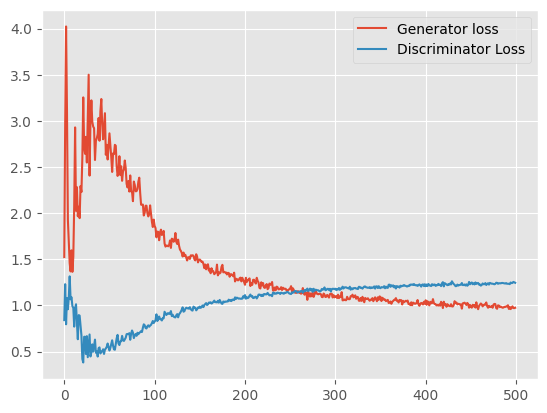

In [22]:
# plot and save the generator and discriminator loss
plt.figure()
losses_g = [i.cpu().detach().numpy() for i in losses_g]
losses_d = [i.cpu().detach().numpy() for i in losses_d]
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig(PATH+'loss.png')

## Using the Generator to create images

In [26]:
generator = Generator(nz)
generator.load_state_dict(torch.load(PATH+'generator.pth'))
discriminator = Discriminator()
discriminator.load_state_dict(torch.load(PATH+'discriminator.pth'))

<All keys matched successfully>

In [27]:
generator.to(device)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [42]:
generated_img = generator(noise).cpu().detach()

In [43]:
save_generator_image(generated_img, PATH+"test.png")